In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pandas as pd

import datetime
import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import get_covid19india_api_data
from data.processing import get_data
from models.ihme.dataloader import get_dataframes_cached

from models.seir.seir_testing import SEIR_Testing
from models.seir.seirhd import SEIRHD
from models.seir.seir_movement import SEIR_Movement
from models.seir.seir_movement_testing import SEIR_Movement_Testing

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast
from utils.create_report import create_report

## Load Covid19india Data

In [15]:
# dataframes = get_covid19india_api_data()
dataframes = get_dataframes_cached()

../../cache/dataframes_ts_03062020.pkl


In [16]:
predictions_dict = {}

## Select Districts to fit on

In [17]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

Performing m1 fit ..
splitting data ..
splitting data ..
train
           state district       date  total_infected  hospitalised  recovered  \
35  maharashtra   mumbai 2020-05-18         21202.6       14853.8     5583.2   
36  maharashtra   mumbai 2020-05-19         22586.8       15811.8     5972.2   
37  maharashtra   mumbai 2020-05-20         24007.0       16783.4     6385.8   
38  maharashtra   mumbai 2020-05-21         25503.4       17849.4     6777.8   
39  maharashtra   mumbai 2020-05-22         27062.6       18979.4     7169.4   

    deceased  
35     765.6  
36     802.8  
37     837.8  
38     876.2  
39     913.8  
val
          state district       date  total_infected  hospitalised  recovered  \
0  maharashtra   mumbai 2020-05-23         28633.4       20125.6     7557.0   
1  maharashtra   mumbai 2020-05-24         30128.2       21171.2     7969.6   
2  maharashtra   mumbai 2020-05-25         31481.6       22092.2     8364.4   
3  maharashtra   mumbai 2020-05-26         3

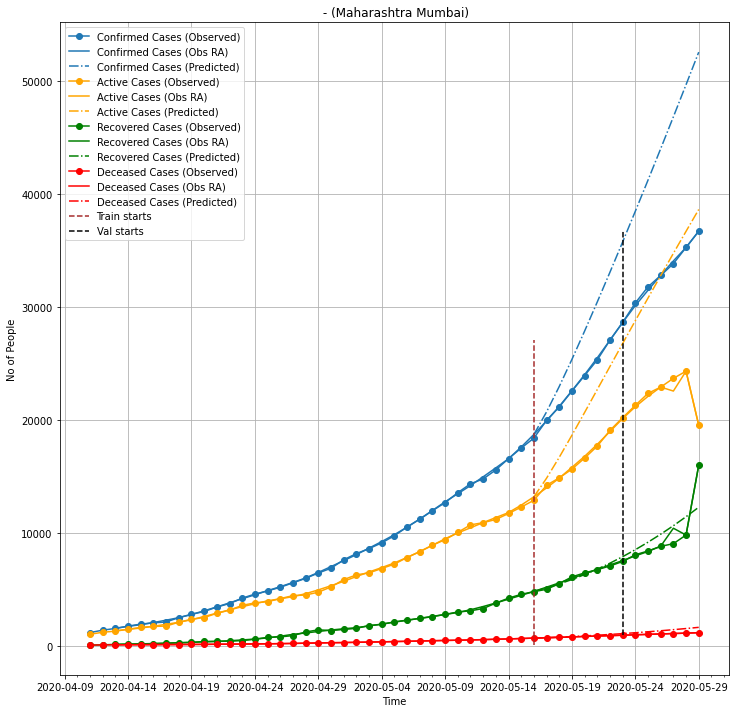

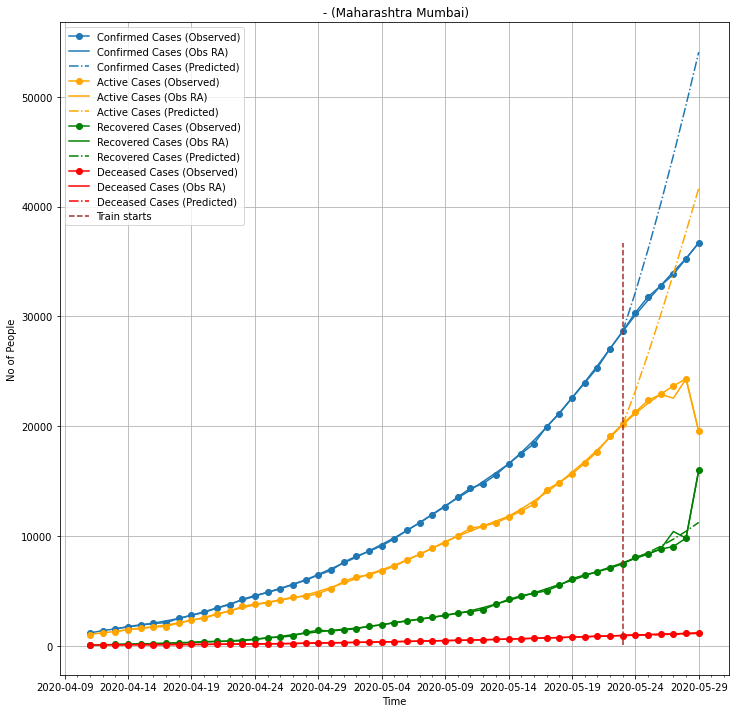

In [7]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=7, num_evals=5,
        data_from_tracker=False, initialisation='intermediate', model=SEIR_Testing, 
        smooth_jump=False, smoothing_method='weighted', smoothing_length=28,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=0, num_evals=5,
        data_from_tracker=False, initialisation='intermediate', model=SEIR_Testing, 
        smooth_jump=False, smoothing_method='weighted', smoothing_length=28,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
    predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

## Create Master Loss Dataframe

### M1 Loss

In [58]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai         6.54           4.22    14.03      4.83   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai        36.94          21.59    42.13     37.32

### M2 Loss

In [59]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai        18.49           6.56    12.95      25.3

## Plot Forecasts

getting forecasts ..


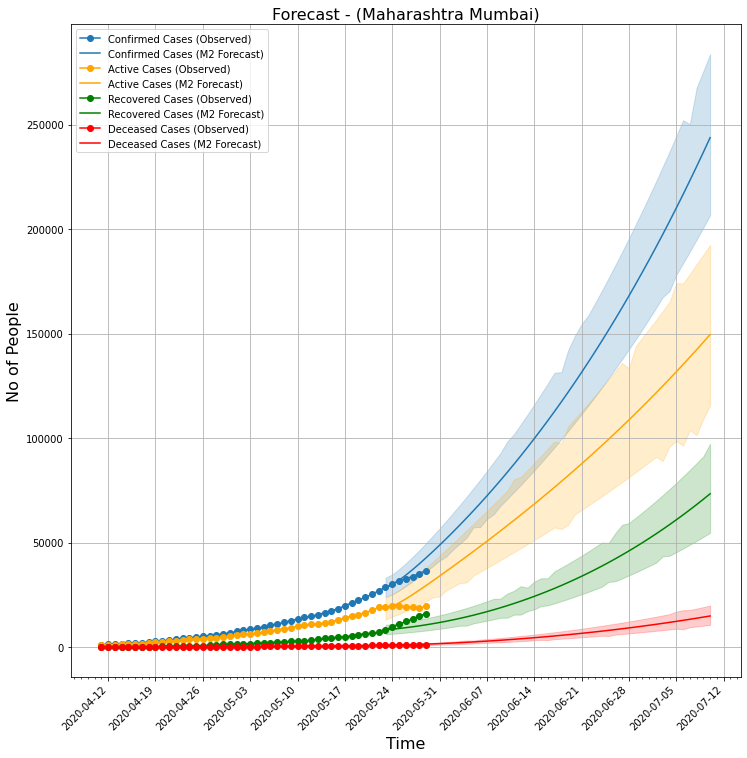

In [60]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create Report (v1)

In [61]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region])

## Create and Save Output CSV

In [62]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [63]:
write_csv(df_output)

In [64]:
## Produce Top 10 Trials / Plots

In [65]:
m = 'm2'

In [66]:
params_array = []
for trial in predictions_dict[(state, district)][m]['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)
params_array = np.array(params_array)

In [67]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)][m]['trials']])
least_losses_indices = np.argsort(losses_array)
top10losses = losses_array[least_losses_indices][:10]

In [68]:
top10params = params_array[least_losses_indices[:10]]

In [69]:
top10predictions = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=params_dict) for params_dict in top10params]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_trials(m_dict, top10losses, top10params, top10predictions):
    df_true = m_dict['df_district']
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_true['date'], df_true['total_infected'],
            '-o', color='C0', label='Confirmed Cases (Observed)')
    for i, df_prediction in enumerate(top10predictions):
        loss_value = np.around(np.sort(top10losses)[:10][i], 2)
        sns.lineplot(x="date", y="total_infected", data=df_prediction,
                    ls='-', label='Confirmed Cases ({})'.format(loss_value))
        plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1], s=loss_value)
        
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People', fontsize=16)
    plt.yscale('log')
    plt.xlabel('Time', fontsize=16)
    plt.legend()
    plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
    #plt.grid()
    return ax

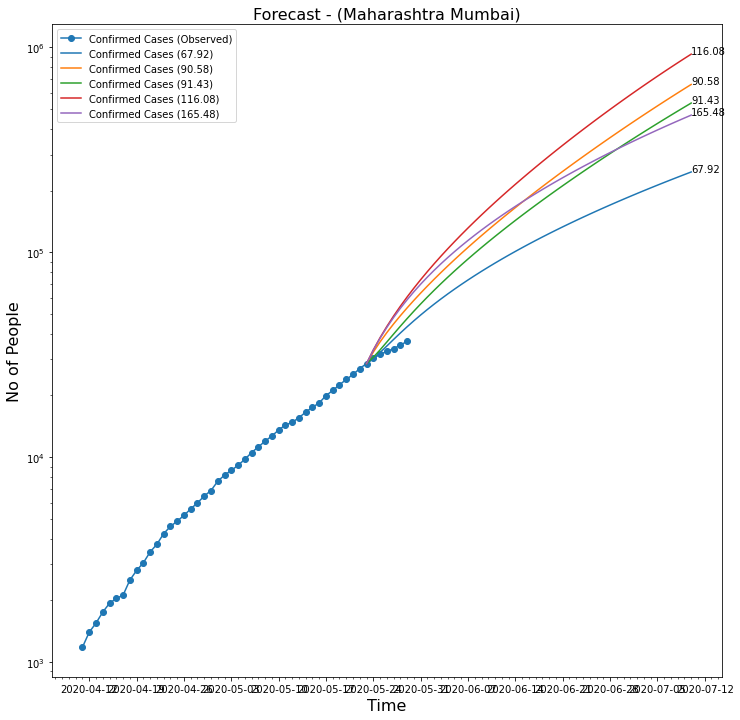

In [71]:
for region in predictions_dict.keys():
    predictions_dict[region][m]['top10params'] = top10params
    predictions_dict[region][m]['forecast_top10'] = plot_trials(predictions_dict[region][m], top10losses, top10params, top10predictions)

In [72]:
import time
for region in predictions_dict.keys():
    t = time.time()
    create_report(predictions_dict[region], ROOT_DIR=f'../../reports/{t}')

In [26]:
from main.seir.fitting import get_regional_data 

orig_df_district, _ = get_regional_data(dataframes, 'Maharashtra', 'Mumbai', data_from_tracker=False, data_format='new', filename=None)

fetching from athenadb...


In [29]:
dataframes
state='Maharashtra'
district='Mumbai'
data_from_tracker=False
smooth_jump=True
smoothing_length=28
smoothing_method='weighted'
filename=None
data_format='new'

if data_from_tracker:
    main_df_district = get_data(dataframes, state=state, district=district, use_dataframe='districts_daily')
else:
    main_df_district = get_data(state=state, district=district, disable_tracker=True, filename=filename, 
                            data_format=data_format)

df_district_raw_data = get_data(dataframes, state=state, district=district, use_dataframe='raw_data')


fetching from athenadb...


In [38]:
df_district=copy.copy(main_df_district)
if smooth_jump:
    if data_from_tracker:
        d1, d2 = '2020-05-29', '2020-05-30'
    else:
        d1, d2 = '2020-05-28', '2020-05-29'
    df_district = df_district.set_index('date')
    big_jump = df_district.loc[d2, 'recovered'] - df_district.loc[d1, 'recovered']
    print(big_jump)
    if smoothing_method == 'linear':
        for i, day_number in enumerate(range(smoothing_length-2, -1, -1)):
            date = datetime.datetime.strptime(d1, '%Y-%m-%d') - datetime.timedelta(days=day_number)
            offset = np.random.binomial(1, (big_jump%smoothing_length)/smoothing_length)
            df_district.loc[date, 'recovered'] += ((i+1)*big_jump)//smoothing_length + offset
            df_district.loc[date, 'hospitalised'] -= ((i+1)*big_jump)//smoothing_length + offset

    elif smoothing_method == 'weighted':
        newcases = df_district['total_infected'].shift(14) - df_district['total_infected'].shift(15)
        idx = newcases.first_valid_index()
        newcases = newcases.loc[idx:]
        truncated = df_district.loc[idx:, :]
        invpercent = newcases.sum()/newcases
        for i, day_number in enumerate(range(smoothing_length-2, -1, -1)):
            date = datetime.datetime.strptime(d1, '%Y-%m-%d') - datetime.timedelta(days=day_number)
            offset = np.random.binomial(1, (big_jump%invpercent.loc[date])/newcases.loc[date])
            truncated.loc[date, 'recovered'] += ((i+1)*big_jump // invpercent.loc[date]) + offset
            truncated.loc[date, 'hospitalised'] -= ((i+1)*big_jump // invpercent.loc[date]) + offset
        df_district.loc[truncated.index, 'recovered'] = truncated['recovered']
        df_district.loc[truncated.index, 'hospitalised'] = truncated['hospitalised']

    assert((df_district['total_infected'] == df_district['hospitalised'] + df_district['deceased'] + df_district['recovered']).all())

6191
0
1559
147.0
0
1804.0
219.0
0
1908.0
286.0
0
2128.0
599.0
0
2287.0
585.0
0
2435.0
1087.0
1
2589.0
948.0
0
2792.0
852.0
0
3004.0
1105.0
0
3110.0
1497.0
1
3313.0
1639.0
0
3791.0
2160.0
0
4234.0
2055.0
0
4568.0
3986.0
0
4806.0
3110.0
0
5012.0
2675.0
0
5516.0
3286.0
0
6116.0
4333.0
0
6466.0
5539.0
0
6751.0
5246.0
0
7080.0
5955.0
0
7476.0
6021.0
0
8074.0
7629.0
0
8404.0
7197.0
0
8814.0
4037.0
0
9054.0
7885.0
0
9817.0
10215.0


In [34]:
offset

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
new_df_district, _ = get_regional_data(dataframes, 'Maharashtra', 'Mumbai', data_from_tracker=False, data_format='new', filename=None, smooth_jump=True, smoothing_length=28, smoothing_method='weighted')

fetching from athenadb...
6191
1559
[147. 148. 147. 148. 148. 148. 147. 147. 147. 147. 147. 147. 147. 147.
 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147. 147.
 147. 147. 147. 147. 147. 147.]


ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
# df_district[44:][-10:]
new_df_district = smooth_using_total(df_district, last_n_days=15, cols=['hospitalised', 'recovered'], method='uniform')
compare_cols = ['total_infected','hospitalised','deceased','recovered']
compare = (df_district[compare_cols][-20:], new_df_district[compare_cols][-20:])
# compare = (new_df_district[compare_cols][-20:])
compare = (df_district[compare_cols] - new_df_district[compare_cols])[-20:]
print (compare)# df_district[44:][-10:]
new_df_district = smooth_using_total(df_district, last_n_days=15, cols=['hospitalised', 'recovered'], method='uniform')
compare_cols = ['total_infected','hospitalised','deceased','recovered']
compare = (df_district[compare_cols][-20:], new_df_district[compare_cols][-20:])
# compare = (new_df_district[compare_cols][-20:])
compare = (df_district[compare_cols] - new_df_district[compare_cols])[-20:]
print (compare)

In [ ]:
ti_check = copy.copy(df_district['total_infected'])
ti_check2 = copy.copy(new_df_district['total_infected'])
for col in ['hospitalised', 'recovered', 'deceased']:
    ti_check -= new_df_district[col]
    ti_check2 -= new_df_district[col]
print(pd.concat([ti_check[-25:], ti_check2[-25:]], axis=1))ti_check = copy.copy(df_district['total_infected'])
ti_check2 = copy.copy(new_df_district['total_infected'])
for col in ['hospitalised', 'recovered', 'deceased']:
    ti_check -= new_df_district[col]
    ti_check2 -= new_df_district[col]
print(pd.concat([ti_check[-25:], ti_check2[-25:]], axis=1))